### Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_columns',500)

In [2]:
tweets_df = pd.read_csv('vaccine_tweets2.csv')

In [3]:
tweets_df.head(2) 

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1388860165538021376,1388860165538021376,2021-05-02 19:47:21 India Standard Time,2021-05-02,19:47:21,530,1243560408025198593,meidastouch,MeidasTouch.com,NaN,"Know your party platforms! Democrats: Jobs, C...",en,[],[],[],44,660,1967,[],[],https://twitter.com/MeidasTouch/status/1388860...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1388841616866115589,1388841616866115589,2021-05-02 18:33:39 India Standard Time,2021-05-02,18:33:39,530,245687754,pti_news,Press Trust of India,NaN,CM Mamata Banerjee asks Centre to provide free...,en,[],[],[],128,537,3888,[],[],https://twitter.com/PTI_News/status/1388841616...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


### Dropping columns with more than 60% null value

In [4]:
tweets_df = tweets_df.loc[:, tweets_df.isnull().mean() < .6]

### Checking dates and converting it into datetime

In [5]:
tweets_df['date']= pd.to_datetime(tweets_df['date']) 

In [6]:
tweets_df['year'] = tweets_df['date'].dt.year
tweets_df['month'] = tweets_df['date'].dt.month

In [7]:
tweets_df['year'].value_counts() 

2021    15209
2020     9725
2019      542
2018      186
2017       69
2015       18
2016       14
2014        9
2013        2
Name: year, dtype: int64

#### Observation
- Most of the tweets are from 2020 onwards so we can make the assumption , the talk of vaccine became more popular since COVID19 started

#### Selecting tweets after 1/1/2020

In [8]:
ts = pd.to_datetime('1/1/2020')
tweets_df_r = tweets_df.loc[tweets_df.date >= ts,: ] 

In [9]:
tweets_df_r.shape

(24934, 25)

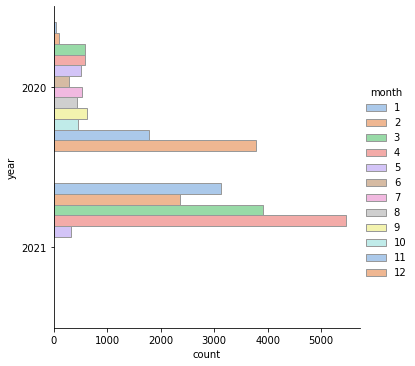

In [10]:
sns.catplot(y="year", hue="month", kind="count",
            palette="pastel", edgecolor=".6",
            data=tweets_df_r)

In [11]:
tweets_df_r.groupby(['year','month']).size().unstack(fill_value=0)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2020,42,110,580,596,505,280,539,435,619,456,1785,3778
2021,3124,2369,3923,5463,330,0,0,0,0,0,0,0


#### Observation
- Clearly the number of tweets with regards to vaccine has been the highest month of April 2021
- Jan 2021 & Feb 2021 had a dip in the number of tweets after taking off in Dec 2020

### Creating a subset and working on it

In [12]:
subset = ['date', 'tweet', 'month','year']
tweets_df_r1 = tweets_df_r.loc[:, subset] 
tweets_df_r1.head() 

,date,tweet,month,year
0,2021-05-02,"Know your party platforms! Democrats: Jobs, C...",5,2021
1,2021-05-02,CM Mamata Banerjee asks Centre to provide free...,5,2021
2,2021-05-02,West Bengal Government needs to be very carefu...,5,2021
3,2021-05-02,Crediting Boris Johnson with beating Covid is ...,5,2021
4,2021-05-02,I got my second Pfizer vaccine shot. I didn’t ...,5,2021


In [13]:
tweets_df_r1.shape

(24934, 4)

### NLTK

In [14]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Adding sentiment through TextBlob
- **Polarity** is a float that lies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments. 
- **Subjectivity** is also a float which lies in the range of [0,1]. Subjective sentences generally refer to personal opinion, emotion, or judgment.It rather quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information

In [15]:
from textblob import TextBlob

In [16]:
def clean_tweet(tweets_df_r1, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ","`", tweet).split())

In [17]:
def sentiment_calc(tweet):
    try:
        return TextBlob(tweet).sentiment
    except:
        return None
    
tweets_df_r1['sentiment'] = tweets_df_r1['tweet'].apply(sentiment_calc)

In [18]:
tweets_df_r2 = tweets_df_r1 
#creating a temporary DF as directly adding columns is throwing errors or creating a DF only with polarity and Subjectivity
sentiment_series = tweets_df_r2['sentiment'].tolist()
columns = ['polarity', 'subjectivity']
tweets_df_r2 = pd.DataFrame(sentiment_series, columns=columns, index=tweets_df_r2.index)

In [19]:
tweets_df_r2.head()

,polarity,subjectivity
0,0.200000,0.400000
1,0.400000,0.800000
2,-0.418333,0.791667
3,-0.068519,0.479630
4,0.000000,0.000000


In [20]:
tweets_df_r2.shape

(24934, 2)

In [21]:
tweets_df_r1['polarity'] = tweets_df_r2['polarity']
tweets_df_r1['subjectivity'] = tweets_df_r2['subjectivity'] 

In [22]:
# create a list of our conditions
conditions = [
    (tweets_df_r1['polarity'] > 0),
    (tweets_df_r1['polarity'] == 0),
    (tweets_df_r1['polarity'] < 0)
    ]

# create a list of the values we want to assign for each condition
values = ['positive', 'neutral', 'negative']

# create a new column and use np.select to assign values to it using our lists as arguments
tweets_df_r1['sentiment1'] = np.select(conditions, values)

# display updated DataFrame
tweets_df_r1.head()

,date,tweet,month,year,sentiment,polarity,subjectivity,sentiment1
0,2021-05-02,"Know your party platforms! Democrats: Jobs, C...",5,2021,"(0.2, 0.4)",0.200000,0.400000,positive
1,2021-05-02,CM Mamata Banerjee asks Centre to provide free...,5,2021,"(0.4, 0.8)",0.400000,0.800000,positive
2,2021-05-02,West Bengal Government needs to be very carefu...,5,2021,"(-0.4183333333333333, 0.7916666666666666)",-0.418333,0.791667,negative
3,2021-05-02,Crediting Boris Johnson with beating Covid is ...,5,2021,"(-0.06851851851851852, 0.47962962962962963)",-0.068519,0.479630,negative
4,2021-05-02,I got my second Pfizer vaccine shot. I didn’t ...,5,2021,"(0.0, 0.0)",0.000000,0.000000,neutral


In [23]:
# create a list of our conditions
conditions = [
    (tweets_df_r1['subjectivity'] < 0.5),
    (tweets_df_r1['subjectivity'] >= 0.5)
    ]

# create a list of the values we want to assign for each condition
values = ['objective', 'subjective']

# create a new column and use np.select to assign values to it using our lists as arguments
tweets_df_r1['sentiment2'] = np.select(conditions, values)

# display updated DataFrame
tweets_df_r1.head() 

,date,tweet,month,year,sentiment,polarity,subjectivity,sentiment1,sentiment2
0,2021-05-02,"Know your party platforms! Democrats: Jobs, C...",5,2021,"(0.2, 0.4)",0.200000,0.400000,positive,objective
1,2021-05-02,CM Mamata Banerjee asks Centre to provide free...,5,2021,"(0.4, 0.8)",0.400000,0.800000,positive,subjective
2,2021-05-02,West Bengal Government needs to be very carefu...,5,2021,"(-0.4183333333333333, 0.7916666666666666)",-0.418333,0.791667,negative,subjective
3,2021-05-02,Crediting Boris Johnson with beating Covid is ...,5,2021,"(-0.06851851851851852, 0.47962962962962963)",-0.068519,0.479630,negative,objective
4,2021-05-02,I got my second Pfizer vaccine shot. I didn’t ...,5,2021,"(0.0, 0.0)",0.000000,0.000000,neutral,objective


In [24]:
tweets_df_r1.sentiment1.replace({'negative': 0, 'positive': 1, 'neutral':2}, inplace = True)

In [25]:
tweets_df_r1.sentiment2.replace({'objective': 0, 'subjective': 1}, inplace = True)

#### Stop words and Corpus

In [26]:
stopwords = list(nltk.corpus.stopwords.words('english'))
new_words=['&amp;',"http","https",'co',"''", '""', '...', '``','@','#',"'","`","http`","http'","t","co","t`","co`",
           '\x89ûï','sxsw\x89û\x9d',"'d","'s","'ll",'//bit.ly/ieavob','&',')','(','“','-','”','*','$',"`","https co",
           "'re","n't",'http','//bit.ly/gvlrin','//j.mp/grn7pk','.',',',':','’','!','?',';','amp','%',"t co","NOT`"]
stopwords.extend(new_words)
print(stopwords) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [27]:
corpus=[]
newtt= tweets_df_r1['tweet'].str.split()
newtt=newtt.values.tolist()
corpus=[word for i in newtt for word in i]

from collections import defaultdict
wordcount=defaultdict(int)
for word in corpus:
    if word not in stopwords:
        wordcount[word]+=1

#### Word level Analysis on through counter function
- A Counter is a container that keeps track of how many times equivalent values are added. It can be used to implement the same algorithms for which bag or multiset data structures are commonly used in other languages.

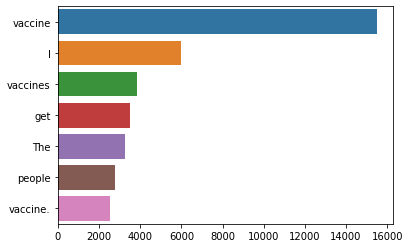

In [28]:
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stopwords):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [29]:
from collections import  Counter

def plot_top_non_stopwords_barchart(tweet):
  
    newtt= tweets_df_r1['tweet'].str.split()
    newtt=newtt.values.tolist()
    corpus=[word for i in newtt for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stopwords):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

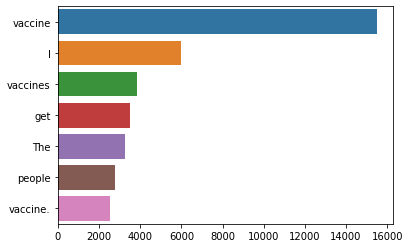

In [30]:
plot_top_non_stopwords_barchart(tweets_df_r1['tweet'])

### Ngram exploration

In [31]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [32]:
def plot_top_ngrams_barchart(tweet, n=2):
      
    newtt= tweets_df_r1['tweet'].str.split()
    newtt=newtt.values.tolist()
    corpus=[word for i in newtt for word in i]


    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]
    for word,count in most[:40]:
        if (word not in stopwords):
            x.append(word)
            y.append(count)
        top_n_bigrams=_get_top_ngram(tweet,n)[:10]
        x,y=map(list,zip(*top_n_bigrams))
        sns.barplot(x=y,y=x)

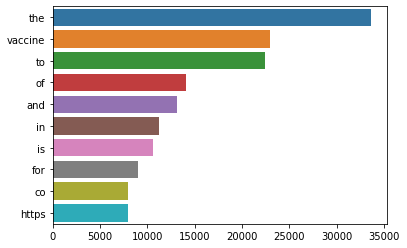

In [33]:
plot_top_ngrams_barchart(tweets_df_r1['tweet'],1)

#### Top N Bigram

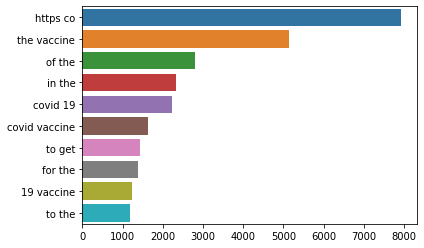

In [34]:
plot_top_ngrams_barchart(tweets_df_r1['tweet'],2)

#### Top N Trigram

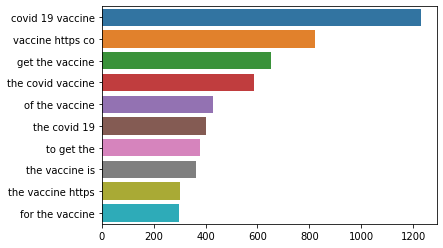

In [35]:
plot_top_ngrams_barchart(tweets_df_r1['tweet'],3) 

#### Top N Quadgram

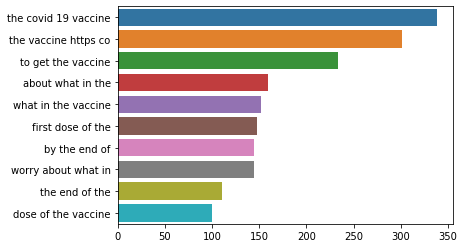

In [36]:
plot_top_ngrams_barchart(tweets_df_r1['tweet'],4)  

In [37]:
tweets_df_r1.head()

,date,tweet,month,year,sentiment,polarity,subjectivity,sentiment1,sentiment2
0,2021-05-02,"Know your party platforms! Democrats: Jobs, C...",5,2021,"(0.2, 0.4)",0.200000,0.400000,1,0
1,2021-05-02,CM Mamata Banerjee asks Centre to provide free...,5,2021,"(0.4, 0.8)",0.400000,0.800000,1,1
2,2021-05-02,West Bengal Government needs to be very carefu...,5,2021,"(-0.4183333333333333, 0.7916666666666666)",-0.418333,0.791667,0,1
3,2021-05-02,Crediting Boris Johnson with beating Covid is ...,5,2021,"(-0.06851851851851852, 0.47962962962962963)",-0.068519,0.479630,0,0
4,2021-05-02,I got my second Pfizer vaccine shot. I didn’t ...,5,2021,"(0.0, 0.0)",0.000000,0.000000,2,0


#### Creating Subset

In [38]:
subset = ['tweet','sentiment1']
tweets_df_r2 = tweets_df_r1.loc[:, subset] 
tweets_df_r2.head() 

,tweet,sentiment1
0,"Know your party platforms! Democrats: Jobs, C...",1
1,CM Mamata Banerjee asks Centre to provide free...,1
2,West Bengal Government needs to be very carefu...,0
3,Crediting Boris Johnson with beating Covid is ...,0
4,I got my second Pfizer vaccine shot. I didn’t ...,2


In [39]:
tweets_df_r2.sentiment1.value_counts()

1    13100
2     6736
0     5098
Name: sentiment1, dtype: int64

##### Setting Target Variable

In [40]:
data = tweets_df_r2.tweet
target = tweets_df_r2.sentiment1

##### removing the stopwords and tokenizing 

In [41]:
## tokenize tweets and remove stopwords
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [42]:
processed_tweet = list(map(process_tweet,tweets_df_r2.tweet)) 

In [43]:
processed_tweet 

[['know',
  'party',
  'platforms',
  'democrats',
  'jobs',
  'checks',
  'covid',
  'relief',
  'vaccines',
  'universal',
  'healthcare',
  'free',
  'education',
  'infrastructure',
  'republicans',
  'insurrection',
  'voter',
  'suppression',
  'dr.',
  'seuss',
  'mr',
  'potato',
  'head',
  'hunter',
  'biden',
  'sex',
  'trafficking',
  'planks',
  'wood',
  'dandelions'],
 ['cm',
  'mamata',
  'banerjee',
  'asks',
  'centre',
  'provide',
  'free',
  'vaccine',
  'every',
  'indian',
  'says',
  'sit',
  'protest',
  'otherwise'],
 ['west',
  'bengal',
  'government',
  'needs',
  'careful',
  'surge',
  'covid',
  'cases',
  'due',
  'election',
  'rallies',
  'started',
  'rubbed',
  'narendra',
  'modi',
  'nose',
  'ground',
  'centre',
  'play',
  'worst',
  'politics',
  'supply',
  'oxygen',
  'vaccines',
  'medicines'],
 ['crediting',
  'boris',
  'johnson',
  'beating',
  'covid',
  'akin',
  'awarding',
  'nobel',
  'peace',
  'prize',
  'vlad',
  'impaler',
  'v

In [44]:
tweet_concat = []
for tweet in processed_tweet:
    tweet_concat += tweet 

In [45]:
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(260) 

[('vaccine', 22530),
 ('vaccines', 6017),
 ('get', 3766),
 ('covid', 3683),
 ('people', 3529),
 ('covid-19', 2164),
 ('first', 2038),
 ('trump', 1840),
 ('us', 1802),
 ('one', 1800),
 ('coronavirus', 1549),
 ('pfizer', 1496),
 ('today', 1483),
 ('got', 1401),
 ('like', 1371),
 ('doses', 1357),
 ('would', 1346),
 ('take', 1346),
 ('million', 1297),
 ('need', 1282),
 ('getting', 1238),
 ('new', 1218),
 ('biden', 1204),
 ('india', 1156),
 ('vaccinated', 1116),
 ('covid19', 1081),
 ('virus', 1029),
 ('dose', 1003),
 ('health', 995),
 ('want', 965),
 ('know', 951),
 ('government', 950),
 ('time', 947),
 ('make', 946),
 ('year', 940),
 ('says', 911),
 ('president', 904),
 ('news', 893),
 ('world', 884),
 ('1', 876),
 ('going', 876),
 ('pandemic', 874),
 ('still', 863),
 ('effective', 861),
 ('day', 846),
 ('everyone', 806),
 ('even', 802),
 ('said', 798),
 ('every', 793),
 ('safe', 789),
 ('work', 769),
 ('go', 741),
 ('could', 738),
 ('uk', 734),
 ('free', 717),
 ('let', 709),
 ('good', 708

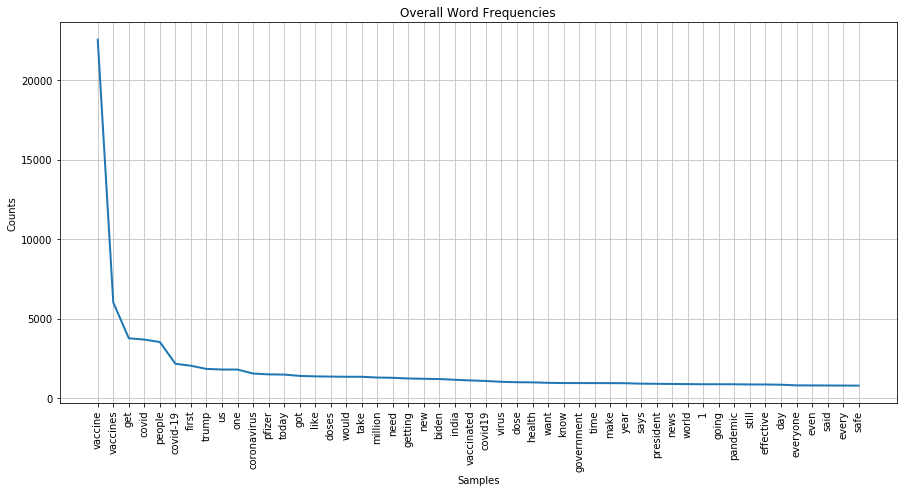

In [46]:
plt.figure(figsize=(15,7))
plt.title('Overall Word Frequencies')
tweet_freqdist.plot(50)

In [47]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_tweet(train_tweets):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for tweet in train_tweets['tweet']:
        words=[w for w in word_tokenize(tweet) if (w not in stopwords)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_tweet(tweets_df_r2) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Bag Of Words using genism & the LDA model: Latent Dirichlet Allocation (LDA)

In [48]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Wordcloud

In [49]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_tweet(tweets_df_r2):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for tweet in tweets_df_r2['tweet']:
        words=[w.strip("`'").lower() for w in word_tokenize(tweet) if (w not in stopwords)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.extend(words)
    return corpus

corpus1=preprocess_tweet(tweets_df_r2)   

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
# from itertools import count
# factory = lambda c=count(): 0 if next(c) % 2 else []
# superdict = defaultdict(factory)

# from collections import defaultdict
wordcount1=defaultdict(int)
for word in corpus1:
    if word not in stopwords:
        wordcount1[word]+=1


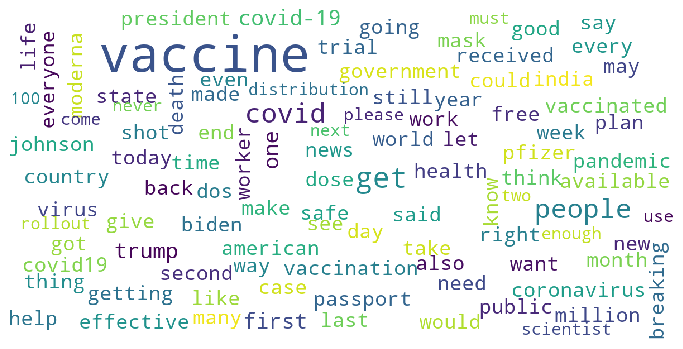

In [51]:
from wordcloud import WordCloud
def show_wordcloud(tweet):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate_from_frequencies(tweet)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(wordcount1) 


In [52]:
np.array(corpus).flatten()  

C:\Users\DELL\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([list(['Know', 'party', 'platform', 'Democrats', 'Jobs', 'Checks', 'Covid', 'Relief', 'Vaccines', 'Universal', 'Healthcare', 'Free', 'Education', 'Infrastructure', 'Republicans', 'Insurrection', 'Voter', 'Suppression', 'Dr.', 'Seuss', 'Potato', 'Head', 'Hunter', 'Biden', 'Sex', 'Trafficking', 'Planks', 'Wood', 'Dandelions']),
       list(['Mamata', 'Banerjee', 'asks', 'Centre', 'provide', 'free', 'vaccine', 'every', 'Indian', 'say', 'sit', 'protest', 'otherwise']),
       list(['West', 'Bengal', 'Government', 'need', 'careful', 'The', 'surge', 'Covid', 'case', 'due', 'election', 'rally', 'started', 'And', 'rubbed', 'Narendra', 'Modi', 'nose', 'ground', 'Centre', 'play', 'worst', 'politics', 'supply', 'Oxygen', 'Vaccines', 'Medicines']),
       ...,
       list(['WaPo', 'run', 'editorial', 'lamenting', 'rise', 'polio', 'Pakistan', 'mistrust', 'among', 'population', 'aid', 'worker', 'without', 'noting', 'role', 'CIA', 'creating', 'mistrust', 'creating', 'fake', 'vaccine', 'program'

#### Lemmantizing data 

In [53]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_tweet:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [54]:
Data = {'tweet':lemmatized_output, 'sentiment1':target}
tweet_lemmantized = pd.DataFrame(Data)

### Spliting into training and testing data sets

In [55]:
train_tweets = tweets_df_r1.sample(frac = 0.75)

In [56]:
test_tweets = tweets_df_r1.drop(train_tweets.index) 

In [57]:
train_tweets.shape

(18700, 9)

In [58]:
test_tweets.shape 

(6234, 9)

### StratifiedShuffleSplit

In [59]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 1, test_size = .25, random_state = 3)
sss.get_n_splits(tweet_lemmantized.tweet, tweet_lemmantized.sentiment1)
for train_ind, test_ind in sss.split(tweet_lemmantized.tweet, tweet_lemmantized.sentiment1):
    pass
print(f'Train_ind shape: {train_ind.shape}\nTest_ind shape: {test_ind.shape}')

Train_ind shape: (18700,)
Test_ind shape: (6234,)


#### tfidf vectorizing

- The TfidfVectorizer() returns floats while the CountVectorizer() returns ints  
- using tfidfVectorizer for model evaluation as TfidfVectorizer() assigns a score while CountVectorizer() counts

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer #
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 50)
X_train = vectorizer.fit_transform(tweet_lemmantized.tweet[train_ind].reset_index(drop = True))
y_train = tweet_lemmantized.sentiment1[train_ind].reset_index(drop = True)
X_test = vectorizer.transform(tweet_lemmantized.tweet[test_ind].reset_index(drop = True))
y_test = tweet_lemmantized.sentiment1[test_ind].reset_index(drop = True)

### Model Evaluation

In [61]:
model_perf = {} # dictionary for storing performance

In [62]:
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#ensembling
from mlxtend.classifier import StackingCVClassifier

#### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# grid searching for optimal c values
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
params = {'C': [.001, .005, .01, .05, .1, .5, 1, 5]}
model = LogisticRegression(max_iter = 1000, random_state = 4)
clf = GridSearchCV(model, param_grid = params, n_jobs = -1)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([ 1.39320984,  0.83911943,  1.05379629,  2.02963672,  2.74003034,
         5.28457203,  7.53827972, 12.65395126]),
 'std_fit_time': array([0.38887208, 0.03812816, 0.04834157, 0.06897712, 0.21313999,
        0.40171019, 0.99364883, 2.58999369]),
 'mean_score_time': array([0.00739727, 0.00479755, 0.00499792, 0.00539775, 0.0059947 ,
        0.00599861, 0.00579691, 0.00599675]),
 'std_score_time': array([6.79571629e-03, 4.00117711e-04, 1.09623685e-03, 4.88267219e-04,
        2.05980406e-06, 6.32260234e-04, 7.48586759e-04, 3.28355814e-03]),
 'param_C': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.005},
  {'C': 0.01},
  {'C': 0.05},
  {'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 5}],
 'split0_test_score': array([0.52540107, 0.52540107, 0.52540107, 0.55187166, 0.60855615,
        0.7382352

In [64]:
X_train.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### Baseline model Logistic Regression

In [65]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_predict1 = lr.predict(X_train)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_conf_matrix1 = confusion_matrix(y_train, lr_predict1)
lr_acc_score = accuracy_score(y_test, lr_predict)
lr_acc_score1 = accuracy_score(y_train, lr_predict1)
print("confussion matrix")
print(lr_conf_matrix)
print(lr_conf_matrix1) 
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print("Accuracy of Logistic Regression:",lr_acc_score1*100,'\n')
print(classification_report(y_test,lr_predict))
print(classification_report(y_train,lr_predict1))


C:\Users\DELL\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


confussion matrix
[[ 603  490  182]
 [ 105 2970  200]
 [  45  375 1264]]
[[2809  748  266]
 [ 106 9547  172]
 [  35  395 4622]]


Accuracy of Logistic Regression: 77.59063201796599 

Accuracy of Logistic Regression: 90.79144385026738 

              precision    recall  f1-score   support

           0       0.80      0.47      0.59      1275
           1       0.77      0.91      0.84      3275
           2       0.77      0.75      0.76      1684

    accuracy                           0.78      6234
   macro avg       0.78      0.71      0.73      6234
weighted avg       0.78      0.78      0.77      6234

              precision    recall  f1-score   support

           0       0.95      0.73      0.83      3823
           1       0.89      0.97      0.93      9825
           2       0.91      0.91      0.91      5052

    accuracy                           0.91     18700
   macro avg       0.92      0.87      0.89     18700
weighted avg       0.91      0.91      0.91     18700



### Model 1 Random Forest Classfier

In [66]:
m1 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=50)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_predicted1 = rf.predict(X_train)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_conf_matrix1 = confusion_matrix(y_train, rf_predicted1)
rf_acc_score = accuracy_score(y_test, rf_predicted)
rf_acc_score1 = accuracy_score(y_train, rf_predicted1)
print("confussion matrix")
print(rf_conf_matrix)
print(rf_conf_matrix1)
print("\n")
print("Accuracy of Random Forest Train:",rf_acc_score*100,'\n')
print("Accuracy of Random Forest Test:",rf_acc_score1*100,'\n')
print(classification_report(y_test,rf_predicted))
print(classification_report(y_train,rf_predicted1)) 

confussion matrix
[[ 144 1100   31]
 [  13 3224   38]
 [   1 1298  385]]
[[1272 2512   39]
 [   0 9806   19]
 [   0 3446 1606]]


Accuracy of Random Forest Train: 60.20211742059672 

Accuracy of Random Forest Test: 67.8288770053476 

              precision    recall  f1-score   support

           0       0.91      0.11      0.20      1275
           1       0.57      0.98      0.72      3275
           2       0.85      0.23      0.36      1684

    accuracy                           0.60      6234
   macro avg       0.78      0.44      0.43      6234
weighted avg       0.72      0.60      0.52      6234

              precision    recall  f1-score   support

           0       1.00      0.33      0.50      3823
           1       0.62      1.00      0.77      9825
           2       0.97      0.32      0.48      5052

    accuracy                           0.68     18700
   macro avg       0.86      0.55      0.58     18700
weighted avg       0.79      0.68      0.63     18700



### Model 2 Extreme Gradient Boost

In [67]:
m2 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='gbtree', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_predicted1 = xgb.predict(X_train)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_conf_matrix1 = confusion_matrix(y_train, xgb_predicted1)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
xgb_acc_score1 = accuracy_score(y_train, xgb_predicted1)
print("confussion matrix")
print(xgb_conf_matrix)
print(xgb_conf_matrix1)
print("\n")
print("Accuracy of Extreme Gradient Boost Test:",xgb_acc_score*100,'\n')
print("Accuracy of Extreme Gradient Boost Train:",xgb_acc_score1*100,'\n')
print(classification_report(y_test,xgb_predicted))
print(classification_report(y_train,xgb_predicted1))

confussion matrix
[[ 201  851  223]
 [  32 2919  324]
 [   1  654 1029]]
[[ 701 2639  483]
 [  46 9048  731]
 [   5 2088 2959]]


Accuracy of Extreme Gradient Boost Test: 66.55437921077959 

Accuracy of Extreme Gradient Boost Train: 67.9572192513369 

              precision    recall  f1-score   support

           0       0.86      0.16      0.27      1275
           1       0.66      0.89      0.76      3275
           2       0.65      0.61      0.63      1684

    accuracy                           0.67      6234
   macro avg       0.72      0.55      0.55      6234
weighted avg       0.70      0.67      0.62      6234

              precision    recall  f1-score   support

           0       0.93      0.18      0.31      3823
           1       0.66      0.92      0.77      9825
           2       0.71      0.59      0.64      5052

    accuracy                           0.68     18700
   macro avg       0.77      0.56      0.57     18700
weighted avg       0.73      0.68      0.

### Model 3 K-NeighborsClassifier 

In [68]:
m3 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_predicted1 = knn.predict(X_train)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_conf_matrix1 = confusion_matrix(y_train, knn_predicted1)
knn_acc_score = accuracy_score(y_test, knn_predicted)
knn_acc_score1 = accuracy_score(y_train, knn_predicted1)
print("confussion matrix")
print(knn_conf_matrix)
print(knn_conf_matrix1)
print("\n")
print("Accuracy of K-NeighborsClassifier Test:",knn_acc_score*100,'\n')
print("Accuracy of K-NeighborsClassifier Train:",knn_acc_score1*100,'\n')
print(classification_report(y_test,knn_predicted))
print(classification_report(y_train,knn_predicted1))

confussion matrix
[[ 300  599  376]
 [ 184 2311  780]
 [  65  710  909]]
[[1244 1544 1035]
 [ 345 7866 1614]
 [ 138 1579 3335]]


Accuracy of K-NeighborsClassifier Test: 56.464549246069936 

Accuracy of K-NeighborsClassifier Train: 66.55080213903743 

              precision    recall  f1-score   support

           0       0.55      0.24      0.33      1275
           1       0.64      0.71      0.67      3275
           2       0.44      0.54      0.48      1684

    accuracy                           0.56      6234
   macro avg       0.54      0.49      0.49      6234
weighted avg       0.57      0.56      0.55      6234

              precision    recall  f1-score   support

           0       0.72      0.33      0.45      3823
           1       0.72      0.80      0.76      9825
           2       0.56      0.66      0.60      5052

    accuracy                           0.67     18700
   macro avg       0.66      0.60      0.60     18700
weighted avg       0.67      0.67      0.

### Model 4 DecisionTreeClassifier 

In [69]:
m4 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 50)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_predicted1 = dt.predict(X_train)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_conf_matrix1 = confusion_matrix(y_train, dt_predicted1)
dt_acc_score = accuracy_score(y_test, dt_predicted)
dt_acc_score1 = accuracy_score(y_train, dt_predicted1)
print("confussion matrix")
print(dt_conf_matrix)
print(dt_conf_matrix1)
print("\n")
print("Accuracy of DecisionTreeClassifier Test:",dt_acc_score*100,'\n')
print("Accuracy of DecisionTreeClassifier Train:",dt_acc_score1*100,'\n')
print(classification_report(y_test,dt_predicted))
print(classification_report(y_train,dt_predicted1))

confussion matrix
[[ 284  590  401]
 [ 213 2441  621]
 [  30  353 1301]]
[[2010  965  848]
 [  33 8450 1342]
 [   5  873 4174]]


Accuracy of DecisionTreeClassifier Test: 64.58132820019249 

Accuracy of DecisionTreeClassifier Train: 78.25668449197862 

              precision    recall  f1-score   support

           0       0.54      0.22      0.32      1275
           1       0.72      0.75      0.73      3275
           2       0.56      0.77      0.65      1684

    accuracy                           0.65      6234
   macro avg       0.61      0.58      0.57      6234
weighted avg       0.64      0.65      0.63      6234

              precision    recall  f1-score   support

           0       0.98      0.53      0.68      3823
           1       0.82      0.86      0.84      9825
           2       0.66      0.83      0.73      5052

    accuracy                           0.78     18700
   macro avg       0.82      0.74      0.75     18700
weighted avg       0.81      0.78      0

### Model 5 Support Vector Classifier 

In [70]:
m5 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_predicted1 = svc.predict(X_train)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_conf_matrix1 = confusion_matrix(y_train, svc_predicted1)
svc_acc_score = accuracy_score(y_test, svc_predicted)
svc_acc_score1 = accuracy_score(y_train, svc_predicted1)
print("confussion matrix")
print(svc_conf_matrix)
print(svc_conf_matrix1)
print("\n")
print("Accuracy of Support Vector Classifier Test:",svc_acc_score*100,'\n')
print("Accuracy of Support Vector Classifier Train:",svc_acc_score1*100,'\n')
print(classification_report(y_test,svc_predicted)) 
print(classification_report(y_train,svc_predicted1))

confussion matrix
[[ 654  451  170]
 [ 127 2938  210]
 [  54  335 1295]]
[[3817    5    1]
 [   0 9823    2]
 [   1    2 5049]]


Accuracy of Support Vector Classifier Test: 78.39268527430221 

Accuracy of Support Vector Classifier Train: 99.94117647058823 

              precision    recall  f1-score   support

           0       0.78      0.51      0.62      1275
           1       0.79      0.90      0.84      3275
           2       0.77      0.77      0.77      1684

    accuracy                           0.78      6234
   macro avg       0.78      0.73      0.74      6234
weighted avg       0.78      0.78      0.78      6234

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3823
           1       1.00      1.00      1.00      9825
           2       1.00      1.00      1.00      5052

    accuracy                           1.00     18700
   macro avg       1.00      1.00      1.00     18700
weighted avg       1.00      1.00 

# **Model Evaluation**

In [71]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Random Forest','Extreme Gradient Boost',
                    'K-Nearest Neighbour','Decision Tree','Support Vector Machine'], 'Test_Accuracy': [lr_acc_score*100,
                   rf_acc_score*100,xgb_acc_score*100,knn_acc_score*100,dt_acc_score*100,svc_acc_score*100], 'Train_Accuracy1': [lr_acc_score1*100,
                   rf_acc_score1*100,xgb_acc_score1*100,knn_acc_score1*100,dt_acc_score1*100,svc_acc_score1*100]})
model_ev

,Model,Test_Accuracy,Train_Accuracy1
0,Logistic Regression,77.590632,90.791444
1,Random Forest,60.202117,67.828877
2,Extreme Gradient Boost,66.554379,67.957219
3,K-Nearest Neighbour,56.464549,66.550802
4,Decision Tree,64.581328,78.256684
5,Support Vector Machine,78.392685,99.941176


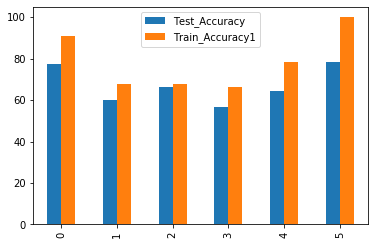

In [72]:
model_ev.plot.bar() 

### Model 6 Naive Bayes

In [117]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train.toarray(),y_train)
nbpred = nb.predict(X_test.toarray())
nbpred1 = nb.predict(X_train)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_conf_matrix1 = confusion_matrix(y_train, nbpred1)
nb_acc_score = accuracy_score(y_test, nbpred)
nb_acc_score1 = accuracy_score(y_train, nbpred1)
print("confussion matrix")
print(nb_conf_matrix)
print(nb_conf_matrix1)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print("Accuracy of Naive Bayes model:",nb_acc_score1*100,'\n')
print(classification_report(y_test,nbpred))
print(classification_report(y_test,nbpred1))  

MemoryError: Unable to allocate 7.39 GiB for an array with shape (24934, 39764) and data type int64

### Feature Importance 
-  Logistic Regression 
- SVM

#### Logistic Regression

In [115]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
lr = LogisticRegression()
# fit the model
lr.fit(X_train, y_train)
# get importance
importance = lr.coef_[0] 
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [24934, 18700]

#### SVM

39764
['00', '000', '00000003', '00001', '00002', '00006', '00007', '00008823529', '00008824', '00009', '0001', '00017', '0003', '0004', '0006', '000s', '000th', '000バイアル', '000箱', '000箱以上をお配りするとお知らせしてきましたが', '000箱近くまで増やし', '001', '002', '005', '006', '007', '008', '009', '00am', '00kjxlnnks', '00pm', '00s', '01', '012', '0120', '015', '019', '01ntpyk9do', '01oyipmqhp', '01wy1i6uyp', '02', '025', '02az8n0lki', '02ba5dykwm', '02nfjf1oa0', '03', '03ajh1y32m', '04', '04dkrbvq1m', '05', '050', '0502iphoig', '051', '055', '056', '05bn', '05ffbiy92c', '05ijzmn6kt', '05iv4nzvpw', '05zmgnzazz', '06', '060', '063', '065', '06bmgftsgh', '06crore', '06pm', '07', '073', '074k1hd9wf', '077', '07aoud0wyr', '07evze6iw4', '07m', '07pnm6dahp', '07wegpogxy', '08', '081', '082', '09', '095', '095fpt5rl6', '09tak1q0zx', '09yzbsxsji', '0aamicgpmp', '0aaqysm6o1', '0abh4s0zeq', '0adnsp9muj', '0b7aeb9fzg', '0bfrdyax7g', '0brcebogfw', '0c3q6n6z88', '0ch8xg7tl2', '0cnu37xeqr', '0coxvksewb', '0cuh2uejgq', '0dmdb

C:\Users\DELL\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


IndexError: index 73221 is out of bounds for axis 0 with size 39764

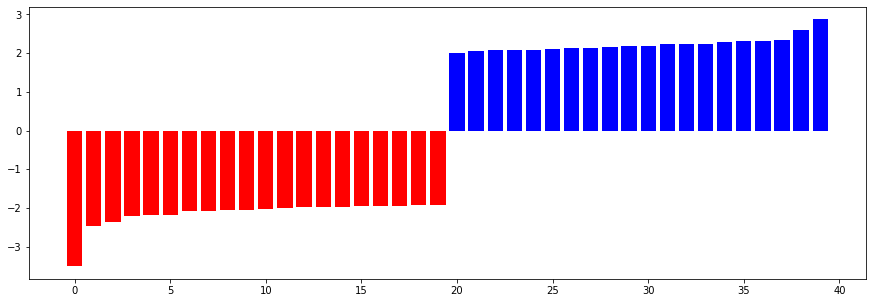

In [111]:
# from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients],color=colors) 
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
vec = CountVectorizer() 
vec.fit(data) 
print (len(vec.vocabulary_)) 
print (vec.get_feature_names())
X_train = vec.transform(data)

svm = LinearSVC()
svm.fit(X_train, target)
plot_coefficients(svm, vec.get_feature_names())  